# Recurrent learning

In this file the network is working with a feedback, online learning is used to make a correction when it might exagerates. 

In [8]:
import csv 
import os 
import math 
import numpy as np
from datetime import datetime
dpath = '/Users/mathisp/Code/S9/reservoir/archive/'

#Makes the time a continuous value to work with ESN.
def time_linearisation(date): 
    format_code = "%Y/%m/%d %H:%M:%S"
    dt = datetime.strptime(date, format_code)
    half_hour_index = dt.hour * 2 + (1 if dt.minute >= 30 else 0)
    hh_sin = math.sin(2 * math.pi * half_hour_index / 48)
    hh_cos = math.cos(2 * math.pi * half_hour_index / 48)

    # Week day
    dow = dt.weekday()
    dow_sin = math.sin(2 * math.pi * dow / 7)
    dow_cos = math.cos(2 * math.pi * dow / 7)

    # Month day
    dom = dt.day - 1
    days_in_month = 31  # number of days in a month approximation
    dom_sin = math.sin(2 * math.pi * dom / days_in_month)
    dom_cos = math.cos(2 * math.pi * dom / days_in_month)

    # Months
    month = dt.month - 1
    month_sin = math.sin(2 * math.pi * month / 12)
    month_cos = math.cos(2 * math.pi * month / 12)

    return np.array([
        hh_sin, hh_cos,
        dow_sin, dow_cos,
        dom_sin, dom_cos,
        month_sin, month_cos
    ])
obj=[]
#Notes Function building the data useful for the training. 
def gathering_data(csv_reader,current_size, ind ):
    here = 0   
    if current_size>1500:
        for row in csv_reader:
            if not row or row[0].startswith("R") or here%6!=0:
                continue
            data[here + ind ,0:8]= np.array(time_linearisation(row[1]))
            data[here + ind ,8]= float(row[2])
            data[here + ind ,9] = float(row[3])
            here+=1
    else :
        for row in csv_reader:
            if not row or row[0].startswith("R"):
                continue
            data[here + ind ,0:8]= np.array(time_linearisation(row[1]))
            data[here + ind ,8]= float(row[2])
            data[here + ind ,9] = float(row[3])
            here+=1
    return data

def size(repo):
    lst = os.listdir("./archive/")
    lst.sort()
    list = []
    # sorting to get data in the chronologic time. 
    for file in lst : 
        size = 0 
        with open(dpath + file, mode = 'r') as file :
            csv_reader = csv.reader(file)
            for row in csv_reader:
                if not row or row[0].startswith("R"):
                    continue
                size +=1
            list.append(size)
    return list



def correcting_size(repo): 
    lst = os.listdir("./archive/")
    lst.sort()
    current= 0 
    new_list =[]
     # sorting to get data in the chronologic time. 
    for file in lst : 
        here =0
        size = 0 
        if list[current]<1500:
            new_list.append(list[current])
            current +=1
            continue 
        else : 
            with open(dpath + file, mode = 'r') as file :
                csv_reader = csv.reader(file)
                for row in csv_reader:
                    if not row or row[0].startswith("R") or here%6!=0:
                        here +=1
                        continue
                    else:
                        here+=1
                        size  +=1
                new_list.append(size)
                current+=1
    return new_list
#Doing it with each file 
list = size(dpath)
final_list = correcting_size(dpath)
data = np.zeros((sum(final_list),10))

def gathering_all(repo):
    lst = os.listdir("./archive/")
    lst.sort()
    current = 0
    ind = 0 
    # sorting to get data in the chronologic time. 
    for file in lst : 
        with open(dpath + file, mode = 'r') as file :
            csv_reader = csv.reader(file)
            current_size = list[current]
            gathering_data(csv_reader, current_size, ind)
        ind += final_list[current]
        current +=1
        

gathering_all(dpath)
print(data[96000:])
print(sum(final_list),len(data))


[]
65712 65712


In [40]:
import matplotlib.pyplot as plt 
def plot_results(y_pred, y_test, sample=30000):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample,8], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample,8], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample,8] - y_pred[:sample,8]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [203]:
from reservoirpy.datasets import to_forecasting
x,y= to_forecasting(data, forecast=10)
print(len(x))
units = 750 
leak_rate = 0.3
spectral_radius = 0.1
input_scaling = 2.0
connectivity = 0.9
input_connectivity = 0.4
regularization = 1e-1
seed = 42
X_train1, y_train1 = x[:30000], y[:30000]
X_test1, y_test1 = x[30000:], y[30000:]
# plot_train_test(X_train1, y_train1, X_test1, y_test1)


65702


In [204]:
from reservoirpy.nodes import RLS
from reservoirpy.nodes import Reservoir 
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = RLS(10)


esn_online = reservoir >> readout

In [205]:
readout = RLS(10)
outputs_pre = np.zeros((len(X_train1), 10))

for t, (x_t, y_t) in enumerate(zip(X_train1, y_train1)):
    outputs_pre[t] = esn_online.partial_fit(
        x_t.reshape(1, -1),
        y_t.reshape(1, -1)
    )

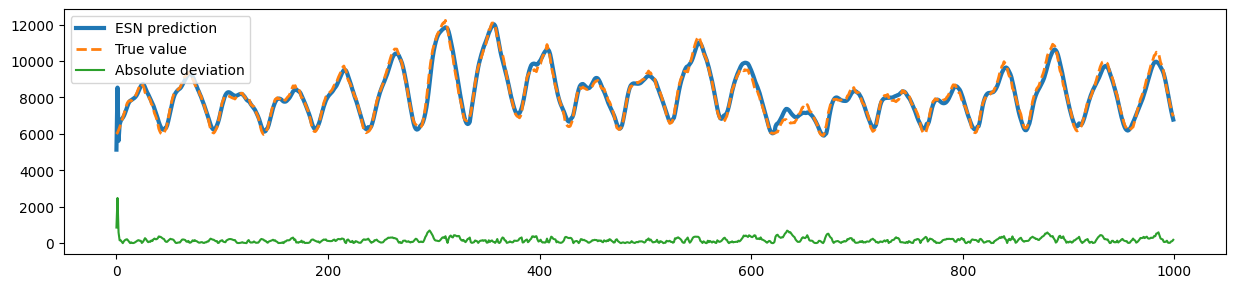

In [206]:
plot_results(outputs_pre, y_train1,1000)

# Online Learning  
With the online learning, values are smoothened by the system as with the simple learning yet values are closer to real one. 

In [181]:
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.nodes import Ridge

In [193]:
#Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
# You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling, 
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [ ]:
import json

hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", [300, 500, 750, 1000]],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [195]:
train_len = 30000
forecast = 10

X_train = x[:train_len]
Y_train = x[forecast : train_len + forecast]

X_test = x[train_len : -forecast]
Y_test = x[train_len + forecast:]

dataset = (X_train, X_test, Y_train, Y_test)

In [196]:
from reservoirpy.datasets import to_forecasting

X_train, X_test, Y_train, Y_test = to_forecasting(x, forecast=forecast, test_size=train_len-forecast)

In [197]:
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [08:24<00:00,  2.52s/trial, best loss=0.0199]


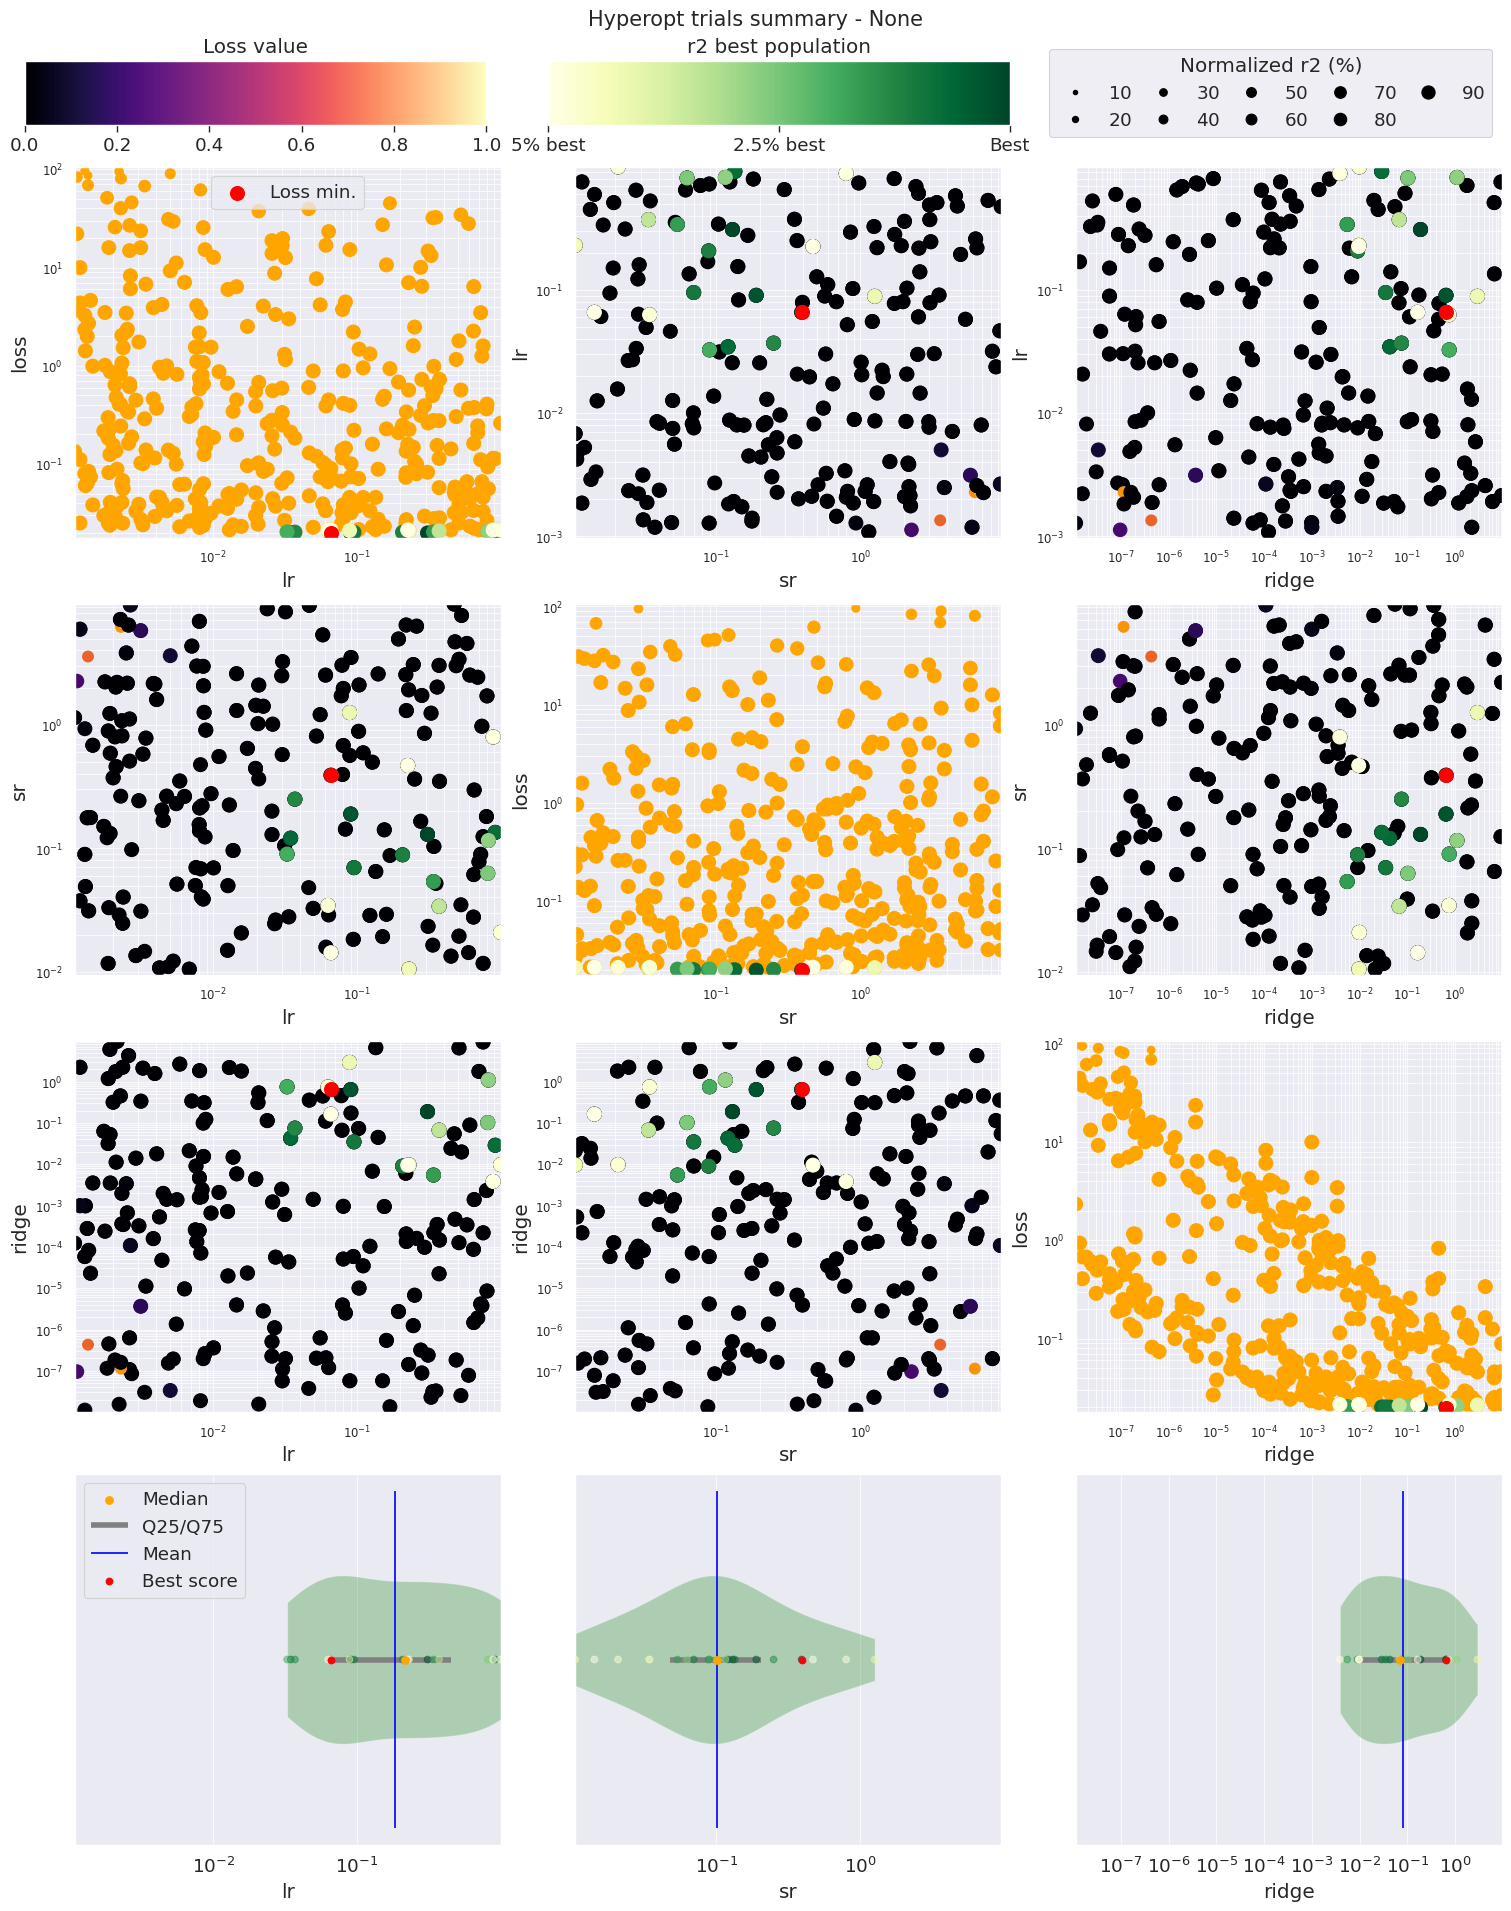

In [198]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")